In [1]:
!pip install monai==1.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.4 MB/s eta 0:00:00


In [2]:
import os
import tempfile
import glob
import random
import numpy as np
import gc
import uuid
import pickle
import time
import re

import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.model_selection import train_test_split

from monai.utils import set_determinism, first
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.transforms import *
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceFocalLoss
from monai.inferers import sliding_window_inference

import torch.nn.functional as F
import torch

2024-08-16 21:05:39.747803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 21:05:39.747933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 21:05:39.893225: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Init

In [3]:
set_determinism(seed=0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
limited = False

num_labels = 3

In [4]:
data_dir = '/kaggle/input/Task03_Liver'
# data_dir = 'Task03_Liver'
data_file_extension = "*.nii"
# data_file_extension = "*.nii.gz"

In [5]:
sample_id = 0

# Train, Val and Test paths

In [6]:
sample_dict = [{"image": glob.glob(os.path.join(data_dir, "imagesTr", data_file_extension))[sample_id], "label": glob.glob(os.path.join(data_dir, "labelsTr", data_file_extension))[sample_id], "meta_data": {"image_path":glob.glob(os.path.join(data_dir, "imagesTr", data_file_extension))[sample_id], "label_path":glob.glob(os.path.join(data_dir, "labelsTr", data_file_extension))[sample_id],}}]
if limited:
    train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", data_file_extension)))[:5]
    train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", data_file_extension)))[:5]
else:
    train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", data_file_extension)))
    train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", data_file_extension)))
data_dict = [{"image": image_name, "label": label_name, "meta_data": {"image_path":image_name, "label_path":label_name,}} for image_name, label_name in zip(train_images, train_labels)]

In [7]:
if limited:
    train_dict, val_dict = train_test_split(data_dict, test_size=0.4, random_state=42)
    val_dict, test_dict = train_test_split(val_dict, test_size=0.01, random_state=42)
else:
    train_dict, val_dict = train_test_split(data_dict, test_size=0.3, random_state=42)
    val_dict, test_dict = train_test_split(val_dict, test_size=0.4, random_state=42)

In [8]:
print(len(train_dict), len(val_dict), len(test_dict))

91 24 16


# Augmenting and Preprocessing

In [9]:
class MapValues(MapTransform):
    def __init__(self, keys, from_value=None, to_value=None, allow_missing_keys=False):
        super().__init__(keys, allow_missing_keys)
        self.from_value = from_value
        self.to_value = to_value
    
    def __call__(self, data):
        if self.from_value==None or self.to_value==None:
            return d
        d = dict(data)
        for key in self.keys:
            if key in d:
                d[key] = np.where(d[key] == self.from_value, self.to_value, d[key])
        return d

In [10]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-70, #Check range
            a_max=120,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2), mode=("bilinear", "nearest")),
        SpatialPadd(keys=["image", "label"], spatial_size=(128, 128, 128)),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(128, 128, 128),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-70, #Check range
            a_max=120,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2), mode=("bilinear", "nearest")),
        SpatialPadd(keys=["image", "label"], spatial_size=(128, 128, 128)),
    ]
)

/opt/conda/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


## Sanity check

In [11]:
def show_plane(ax, plane, cmap="gray", title=None, mask=True):
    if not mask: 
        ax.imshow(plane, cmap=cmap)
    else:
        colors = ["black", "green", "red"]
        cmap = ListedColormap(colors)
        boundaries = [-0.5, 0.5, 1.5, 2.5]
        norm = BoundaryNorm(boundaries, cmap.N, clip=True)
        ax.imshow(plane.astype(float), cmap=cmap, norm=norm, interpolation='nearest')
        
    ax.axis("off")
    if title:
        ax.set_title(title)


In [12]:
# check_ds = Dataset(data=sample_dict, transform=train_transforms)
# check_loader = DataLoader(check_ds, batch_size=1)
# check_data = first(check_loader)

# print(check_data['meta_data'])

# print(check_data['image'].shape)
# print(check_data['label'].shape)

# image, label = (check_data["image"].cpu().numpy()[0][0], check_data["label"].cpu().numpy()[0][0])
# print(f"image shape: {image.shape}, label shape: {label.shape}")

# _, (a, b) = plt.subplots(ncols=2, figsize=(15, 5))

# t = 0

# show_plane(a, image[:, :, t], title=f'Image')
# show_plane(b, label[:, :, t], title=f'Mask', cmap=None) 

# Data Sets and Data loaders 

In [13]:
train_ds = CacheDataset(data=train_dict, transform=train_transforms, cache_rate=1.0, num_workers=4)
val_ds = CacheDataset(data=val_dict, transform=val_transforms, cache_rate=1.0, num_workers=4)

Loading dataset: 100%|██████████| 24/24 [02:09<00:00,  5.38s/it]


In [14]:
train_loader = DataLoader(train_ds, batch_size=1, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

# Train

In [15]:
def get_recent_checkpoint(dir_path, idx=0, ):
    paths = glob.glob(dir_path+'/*')
    
    if len(paths)==0:
        print('UUID not found')
        return None, None
    
    a = []
    for path in paths:
        data_file = path.split('/')[-1]
        epoch = re.findall(r'\d+', data_file)
        a.append(int(epoch[0]))
   
    if len(a)>0:
        recent_epoch = sorted(a, reverse=True)[idx]
    else:
        return None, None
   
    return recent_epoch, f'{dir_path}/data_{recent_epoch}.pkl'

## Model, loss, optimizer, metrics and checkpoint

In [16]:
print('Using device:', device)

# Loss function
loss_function = DiceFocalLoss( to_onehot_y=True, softmax=True)

# Metric
dice_metric = DiceMetric( reduction="mean")#include_background=False,

# Config
config = {
    'run_id': str(uuid.uuid4()),
    'current_epoch': 0,
    'max_epochs': 2 if limited else 200,
    'lr': 10**-4,
    'depth': 5,
    'strides': (2, 2, 2, 2),
    'channels': (16, 32, 64, 128, 256),
    'out_channels': num_labels,
    'norm': 'Norm.BATCH',
    }
    
#Utils
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=num_labels)])
post_label = Compose([AsDiscrete(to_onehot=num_labels)])

#Setting
if limited:
    verbose = True
    config['test_interval']=1
else:
    verbose = False
    config['test_interval']=4

Using device: cuda


In [17]:
idx, checkpoint_path = get_recent_checkpoint(dir_path='/kaggle/input/tl-pan/ea9d559e-2a15-4001-abf9-b9bd28f43c7d', idx=0)

print("No checkpoint found" if checkpoint_path == None else "Checkpoint found")
print(idx, checkpoint_path)

checkpoint_data = None

if checkpoint_path!=None:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     with open(checkpoint_path, 'rb') as fp:
#         best_checkpoint_data = pickle.load(fp)

    best_checkpoint_data = torch.load(checkpoint_path, map_location=device)

    config = best_checkpoint_data['config']
    
    exclude_list = ['config', 'net_state_dict', 'optimizer_state_dict']
    
    checkpoint_data = {}
    
    for i in best_checkpoint_data.keys():
        if i not in exclude_list:
            checkpoint_data[i] = best_checkpoint_data[i]
            
    config['current_epoch']+=1

UUID not found
No checkpoint found
None None


In [18]:
# Model
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=config['out_channels'],
    channels=config['channels'],
    strides=config['strides'],
    num_res_units=config['depth']-1,
    norm=Norm.BATCH,
    ).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), config['lr'])

if checkpoint_path!=None:
    model.load_state_dict(best_checkpoint_data["net_state_dict"])
    optimizer.load_state_dict(best_checkpoint_data["optimizer_state_dict"])

In [19]:
def train(model, config, optimizer, loss_function, dice_metric, post_pred, post_label, verbose, checkpoint_data=None):
    
    best_score = -100000 if checkpoint_data==None else checkpoint_data['best_score']
    best_config = {} if checkpoint_data==None else checkpoint_data['best_config']

    per_epoch_loss = [] if checkpoint_data==None else checkpoint_data['per_epoch_loss']
    per_epoch_vloss = [] if checkpoint_data==None else checkpoint_data['per_epoch_vloss']
    metrics = [] if checkpoint_data==None else checkpoint_data['metrics']
    train_epoch_times = [] if checkpoint_data==None else checkpoint_data['train_epoch_times']
    full_epoch_times = [] if checkpoint_data==None else checkpoint_data['full_epoch_times']
    
    max_epochs = config['max_epochs']
    
    save_history = [] if checkpoint_data==None else checkpoint_data['save_history']
    
    for epoch in range(config['current_epoch'], max_epochs):
        
        print("-" * 25)
        print(f"epoch {epoch + 1}/{max_epochs}")

        train_epoch_start_time = time.time()
        full_epoch_start_time = time.time()

        model.train()

        train_epoch_loss = 0

        config['current_epoch'] = epoch
        
        for idx_data, data in enumerate(train_loader):
            inputs = data["image"].to(device)
            labels = data["label"].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = loss_function(outputs, labels) 
            loss.backward()

            optimizer.step()

            train_epoch_loss += loss.item()
            if verbose:    
                print(f"Batch {idx_data+1}/{len(train_ds)}, " f"train_loss: {loss.item():.4f}")

        train_epoch_times.append(train_epoch_start_time-time.time())

        train_epoch_loss /= len(train_ds)
        per_epoch_loss.append(train_epoch_loss)
        print("-" * 10)
        print(f"Train epoch {epoch + 1} loss: {train_epoch_loss:.4f}")

        if epoch%config['test_interval']==0:

            model.eval()

            if verbose:
                print("-" * 15)

            val_epoch_loss = 0

            with torch.no_grad():
                for idx_data,data in enumerate(val_loader):
                    inputs = data["image"].to(device)
                    labels = data["label"].to(device)

                    roi_size = (128, 128, 128)
                    sw_batch_size = 4
                    
                    outputs = sliding_window_inference(inputs, roi_size, sw_batch_size, model, overlap=0, mode='constant')

                    loss = loss_function(outputs, labels)
                    val_epoch_loss += loss.item()
                    val_outputs = [post_pred(i) for i in decollate_batch(outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(labels)]
                    dice_metric(y_pred=val_outputs, y=val_labels)
                    if verbose: 
                        print(f"Batch {idx_data+1}/{len(val_ds) // val_loader.batch_size}, " f"val_loss: {loss.item():.4f}")

                metric = dice_metric.aggregate().item()
                dice_metric.reset()

            val_epoch_loss /= len(val_loader)
            per_epoch_vloss.append(val_epoch_loss)

            if verbose:
                print("-" * 10)

            print(f"Val epoch {epoch + 1} loss: {val_epoch_loss:.4f}")

            if verbose:
                print("-" * 20)

            metrics.append(metric)
            print("Dice Loss: ", metric)

            if metric>=best_score:
                best_config = config
                best_score = metric
                checkpoint_data = {
                'config':config, 
                'per_epoch_loss': per_epoch_loss,
                'per_epoch_vloss': per_epoch_vloss,
                'metrics':metrics,
                "net_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                'train_epoch_times': train_epoch_times,
                'full_epoch_times': full_epoch_times,
                'best_config': best_config,
                'best_score': best_score,
                'save_history': save_history,
                }
                if not os.path.exists(os.path.join('/kaggle/working/',str(config['run_id']))):
                    os.mkdir(os.path.join('/kaggle/working/',str(config['run_id'])))
#                 with open(os.path.join('/kaggle/working/',os.path.join(config['run_id'], f'data_{epoch}.pkl')), 'wb') as fp:
#                     pickle.dump(checkpoint_data, fp)
                file_path = os.path.join('/kaggle/working/',os.path.join(config['run_id'], f'data_{epoch}.pkl'))
                torch.save(checkpoint_data, file_path)
                
                print(f"Checkpoint created: ({os.path.join('/kaggle/working/',os.path.join(config['run_id'], f'data_{epoch}.pkl'))})")
                
                if os.path.join('/kaggle/working/',os.path.join(config['run_id'], f'data_{epoch}.pkl')) not in save_history:
                    save_history.append(os.path.join('/kaggle/working/',os.path.join(config['run_id'], f'data_{epoch}.pkl')))
                if len(save_history)>3:
                    for i in save_history[:-3]:
                        if os.path.exists(i):
                            os.remove(i)

        full_epoch_times.append(full_epoch_start_time-time.time())

    checkpoint_data = {
        'config':config, 
        'per_epoch_loss': per_epoch_loss,
        'per_epoch_vloss': per_epoch_vloss,
        'metrics':metrics,
        "net_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        'train_epoch_times': train_epoch_times,
        'full_epoch_times': full_epoch_times,
        'best_config': best_config,
        'best_score': best_score,
        'save_history': save_history,
    }
    
    if os.path.join('/kaggle/working/',os.path.join(config['run_id'], f'data_{epoch}.pkl')) not in save_history:
        save_history.append(os.path.join('/kaggle/working/',os.path.join(config['run_id'], f'data_{epoch}.pkl')))
    
    if not os.path.exists(os.path.join('/kaggle/working/',str(config['run_id']))):
        os.mkdir(os.path.join('/kaggle/working/',str(config['run_id'])))
#     with open(os.path.join('/kaggle/working/',os.path.join(config['run_id'], f'data_{epoch}.pkl')), 'wb') as fp:
#         pickle.dump(checkpoint_data, fp)
    file_path = os.path.join('/kaggle/working/',os.path.join(config['run_id'], f'data_{epoch}.pkl'))
    torch.save(checkpoint_data, file_path)
    print(f"Checkpoint created: ({os.path.join('/kaggle/working/',os.path.join(config['run_id'], f'data_{epoch}.pkl'))})")

    print('-'*50)
    print('Run complete.')
    print('-'*50)
    
    return best_config

In [20]:
best_config = train(model, config, optimizer, loss_function, dice_metric, post_pred, post_label, verbose, checkpoint_data)

-------------------------
epoch 1/200


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


----------
Train epoch 1 loss: 0.8916
Val epoch 1 loss: 0.8502
Dice Loss:  0.5183875560760498
Checkpoint created: (/kaggle/working/81dc3d21-fca0-495b-a0b5-5480a060fd6b/data_0.pkl)
-------------------------
epoch 2/200
----------
Train epoch 2 loss: 0.7612
-------------------------
epoch 3/200
----------
Train epoch 3 loss: 0.6804
-------------------------
epoch 4/200
----------
Train epoch 4 loss: 0.6206
-------------------------
epoch 5/200
----------
Train epoch 5 loss: 0.5568
Val epoch 5 loss: 0.5581
Dice Loss:  0.6672852635383606
Checkpoint created: (/kaggle/working/81dc3d21-fca0-495b-a0b5-5480a060fd6b/data_4.pkl)
-------------------------
epoch 6/200
----------
Train epoch 6 loss: 0.5473
-------------------------
epoch 7/200
----------
Train epoch 7 loss: 0.5238
-------------------------
epoch 8/200
----------
Train epoch 8 loss: 0.4976
-------------------------
epoch 9/200
----------
Train epoch 9 loss: 0.4811
Val epoch 9 loss: 0.4615
Dice Loss:  0.6982889771461487
Checkpoint cre

# Evaluation

In [21]:
eval_ = False

In [22]:
if eval_ == True:
    run_id = config['run_id']
    start_epoch, checkpoint_path = get_recent_checkpoint(dir_path=f'/kaggle/input/parch-cp-1/{run_id}')
else:
    config = best_config
    run_id = config['run_id']
    start_epoch, checkpoint_path = get_recent_checkpoint(dir_path=f'/kaggle/working/{run_id}')

# with open(checkpoint_path, 'rb') as fp:
#     best_checkpoint_data = pickle.load(fp)
best_checkpoint_data = torch.load(checkpoint_path)

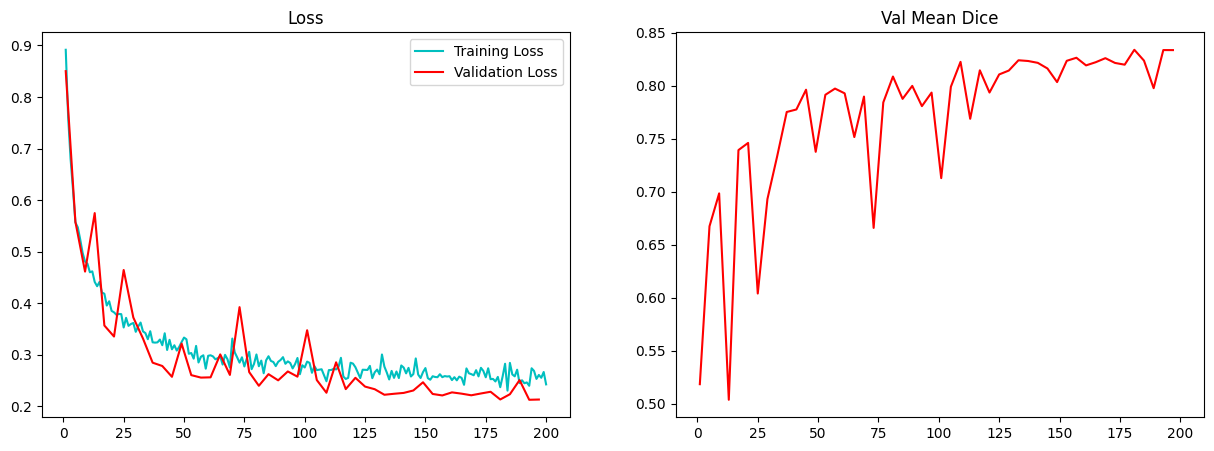

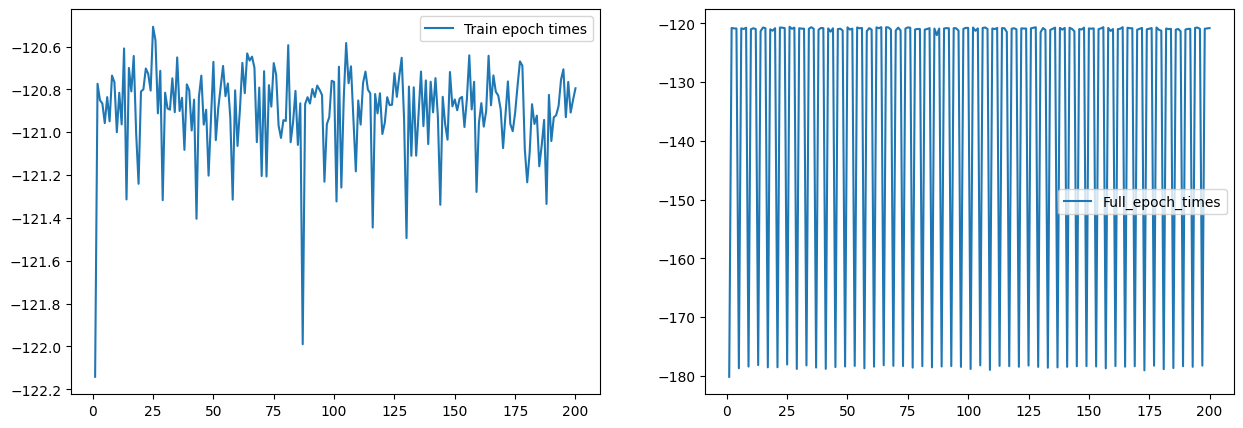

In [23]:
per_epoch_loss = best_checkpoint_data['per_epoch_loss']
per_epoch_vloss = best_checkpoint_data['per_epoch_vloss']
metrics = best_checkpoint_data['metrics']
train_epoch_times = best_checkpoint_data['train_epoch_times']
full_epoch_times = best_checkpoint_data['full_epoch_times']
test_interval = config['test_interval']

_, (a, b) = plt.subplots(ncols=2, figsize=(15, 5), sharex=True)

a.plot(list(range(1, len(per_epoch_loss)+1)), per_epoch_loss, label='Training Loss', color='c')
a.plot(list(range(1,len(per_epoch_vloss)*test_interval+1,test_interval)), per_epoch_vloss, label='Validation Loss', color='r')
a.set_title('Loss')
# a.xlabel('Epochs')
# a.ylabel('Loss')
a.legend()

b.plot(list(range(1,len(per_epoch_vloss)*test_interval+1,test_interval)), metrics, label='Validation Mean Dice', color='r')
b.set_title('Val Mean Dice')
# b.xlabel('Epochs')
# b.ylabel('Val Mean Dice')

_, (a, b) = plt.subplots(ncols=2, figsize=(15, 5), sharex=True)

a.plot(list(range(1, len(train_epoch_times)+1)), train_epoch_times, label='Train epoch times')
a.legend()

b.plot(list(range(1, len(full_epoch_times)+1)), full_epoch_times, label='Full_epoch_times')
b.legend()


In [24]:
# len(per_epoch_loss), len(per_epoch_vloss), len(metrics), len(train_epoch_times), len(full_epoch_times)

# Best model output viz

In [25]:
best_trained_model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=config['out_channels'],
    channels=config['channels'],
    strides=config['strides'],
    num_res_units=config['depth']-1,
    norm=Norm.BATCH,
    ).to(device)

model.load_state_dict(best_checkpoint_data["net_state_dict"])
            
best_trained_model.eval()
print()

In [26]:
to_pred = Compose([AsDiscrete(argmax=True, to_onehot=None)])

In [27]:
plot_interval = 5

tensor([0.8375])


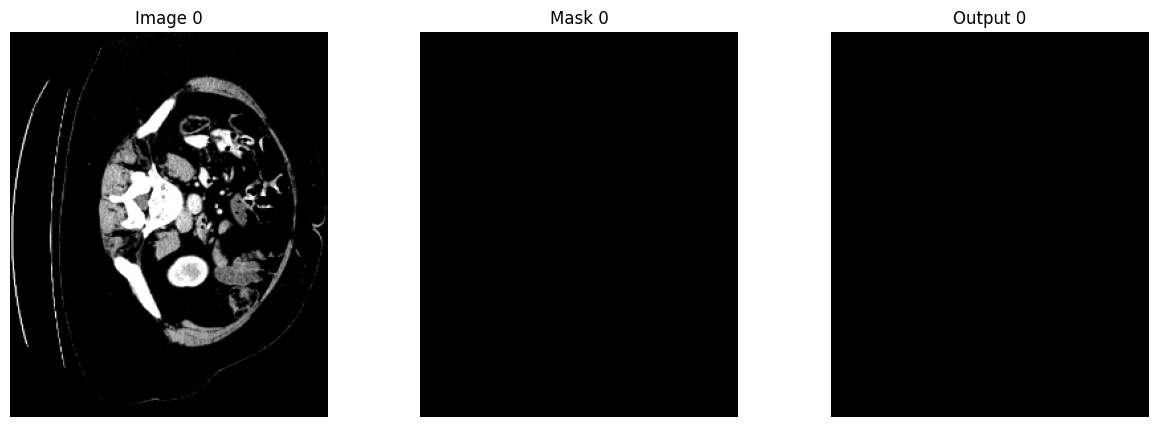

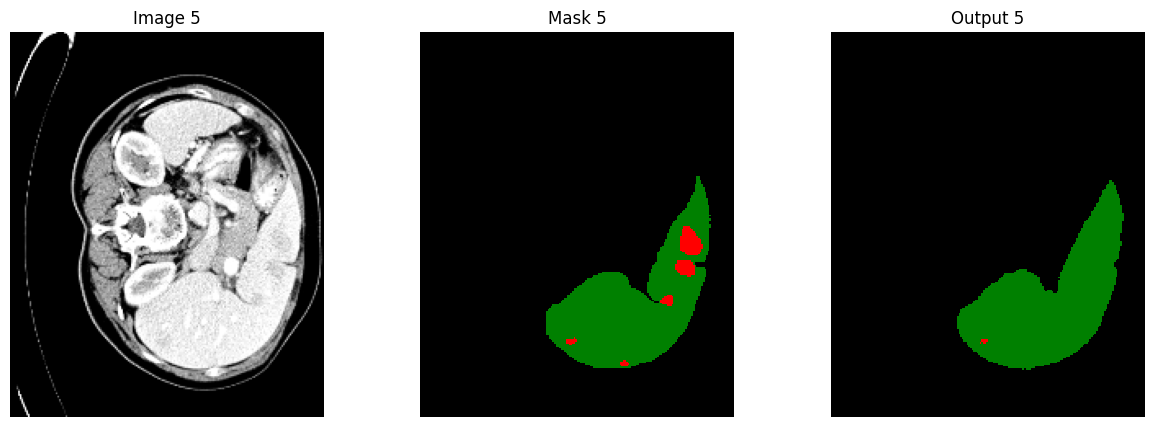

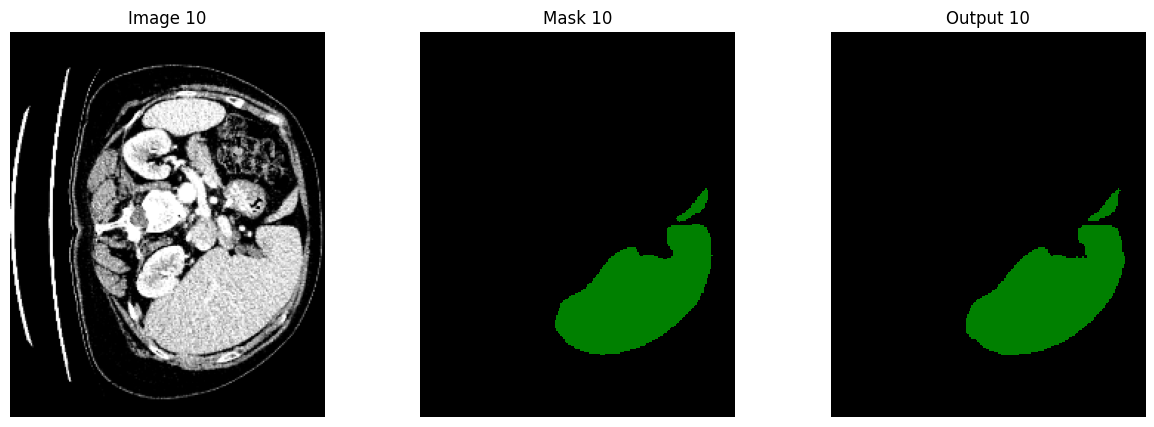

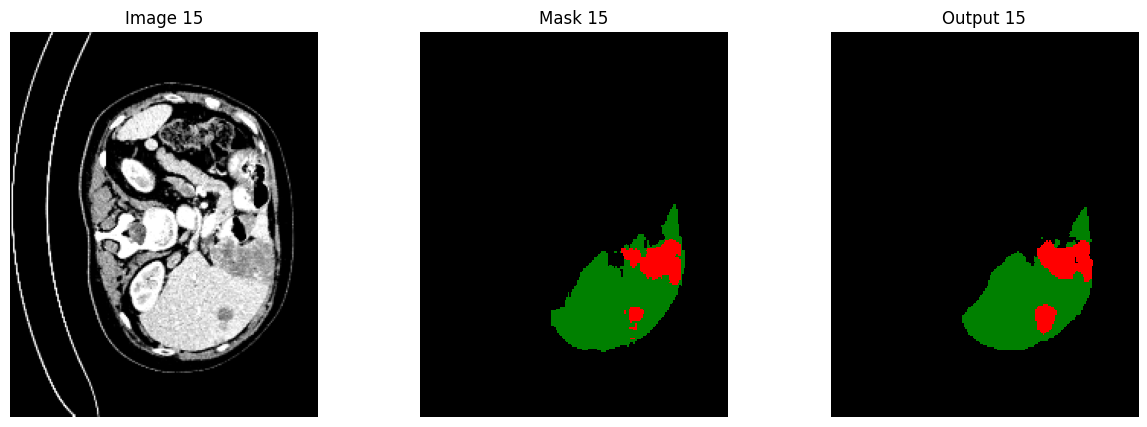

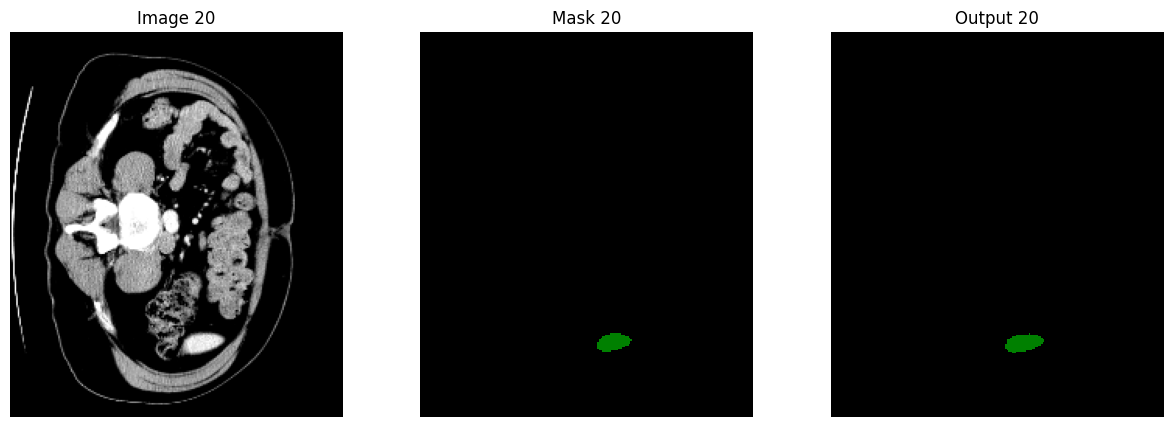

In [28]:
with torch.no_grad():
    for ix, data in enumerate(val_loader):
        roi_size = (128, 128, 128)
        sw_batch_size = 4
        
        outputs = sliding_window_inference(data["image"].to(device), roi_size, sw_batch_size, model, device="cpu", overlap=0, mode='constant')
        
        val_outputs = [post_pred(i) for i in decollate_batch(outputs)]
        val_labels = [post_label(i) for i in decollate_batch(data['label'])]
        dice_metric(y_pred=val_outputs, y=val_labels)
            
        if ix%plot_interval==0:
            prediction = [to_pred(i) for i in decollate_batch(outputs)]
        
            _, (a, b, c) = plt.subplots(ncols=3, figsize=(15, 5))

            t = outputs[0].shape[-1]//2
            show_plane(a, data["image"][0,0,:, :, t], title=f'Image {ix}', mask=False)
            show_plane(b, data["label"][0,0,:, :, t], title=f'Mask {ix}') 
            show_plane(c, prediction[0][0][:, :, t], title=f'Output {ix}') 
            
metric = dice_metric.aggregate()
dice_metric.reset()

print(metric)

In [29]:
np.unique(prediction[0].flatten())

array([0., 1., 2.], dtype=float32)